<a href="https://colab.research.google.com/github/balnarendrasapa/denoiser/blob/model/Denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from keras.datasets import mnist
import numpy
import matplotlib.pyplot as plt

In [60]:
class CustomMnist(Dataset):

  def __init__(self):
      super().__init__()

      # Load Dataset
      (X_train_o, y_train), (X_test_o, y_test) = mnist.load_data()

      # Flattening
      num_pixels = X_train_o.shape[1] * X_train_o.shape[2]
      X_train_o = X_train_o.reshape(X_train_o.shape[0], num_pixels).astype('float32')
      X_test_o = X_test_o.reshape(X_test_o.shape[0], num_pixels).astype('float32')

      # Scaling
      self.Y_train = torch.tensor(X_train_o / 255)
      self.Y_test = torch.tensor(X_test_o / 255)

      # add noise to the images
      noise_factor = 0.2
      X_train = X_train_o + noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=X_train_o.shape)
      X_test = X_test_o + noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=X_test_o.shape)
      self.X_train = torch.tensor(numpy.clip(X_train, 0., 1.), dtype=torch.float)
      self.X_test = torch.tensor(numpy.clip(X_test, 0., 1.), dtype = torch.float)

  def __len__(self):

      return self.X_train.shape[0]

  def __getitem__(self, index):

      sample = self.X_train[index, :]
      label = self.Y_train[index, :]

      return sample, label

In [61]:
dataset = CustomMnist()

In [62]:
len(dataset)

60000

In [63]:
dataloader = DataLoader(dataset, batch_size = 200, shuffle = True)

In [64]:
for batch in dataloader:
  samples, labels = batch
  print(samples.shape, labels.shape)
  break

torch.Size([200, 784]) torch.Size([200, 784])


Train Images


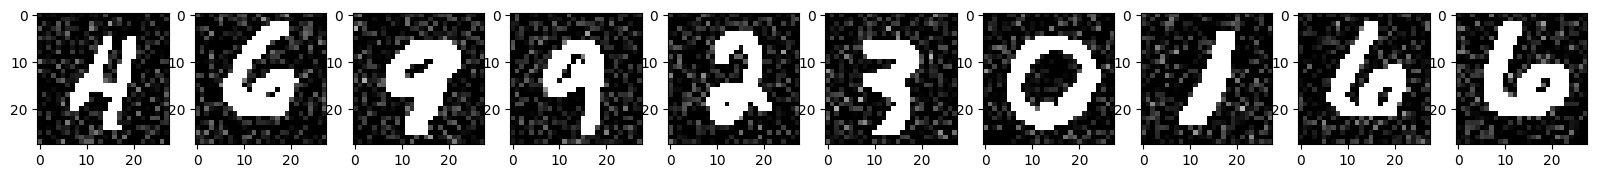

Train labels


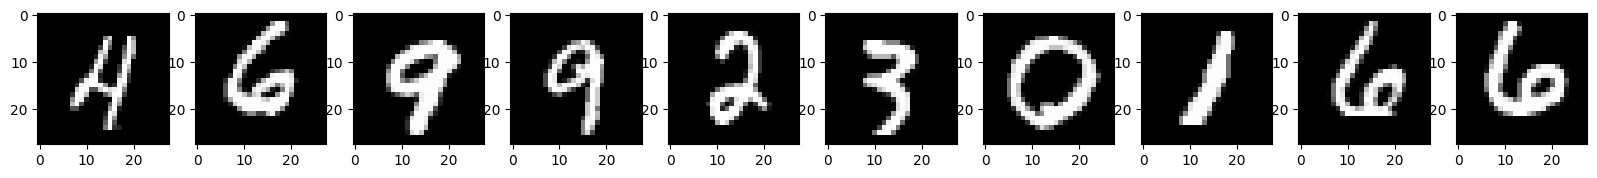

In [65]:
samples = numpy.reshape(samples, (200,28,28)) *255
labels = numpy.reshape(labels, (200,28,28)) *255
plt.figure(figsize=(20, 4))

print("Train Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(samples[i-10,:,:], cmap='gray')
plt.show()

plt.figure(figsize=(20, 4))
print("Train labels")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(labels[i-10,:,:], cmap='gray')
plt.show()

In [66]:
import torch.nn as nn

class Encoder(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(784, 500),
        nn.ReLU(),
        nn.Linear(500, 300),
        nn.ReLU(),
        nn.Linear(300, 100),
        nn.ReLU()
    )

  def forward(self, x):
    return self.model(x)

In [67]:
class Decoder(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(100, 300),
        nn.ReLU(),
        nn.Linear(300, 500),
        nn.ReLU(),
        nn.Linear(500, 784),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

In [68]:
encoder = Encoder()
decoder = Decoder()

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [70]:
encoder

Encoder(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=100, bias=True)
    (5): ReLU()
  )
)

In [71]:
decoder

Decoder(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [72]:
encoder.to(device)
decoder.to(device)

Decoder(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [73]:
loss_function = nn.MSELoss().to(device)

In [76]:
import torch.optim as optim
learning_rate = 0.01

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

In [77]:
for _ in range(5):
    encoder.train()
    decoder.train()
    for batch in dataloader:
        sample, label = batch
        sample, label = sample.to(device), label.to(device)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_output = encoder(sample)
        decoder_output = decoder(encoder_output)

        loss = loss_function(decoder_output, label)
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

    encoder.eval()
    decoder.eval()

# At this point, you have completed 3 epochs of training
loss

tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward0>)

In [78]:
output = decoder(encoder(dataset.X_test.to(device)))

In [79]:
output.shape

torch.Size([10000, 784])

Test samples


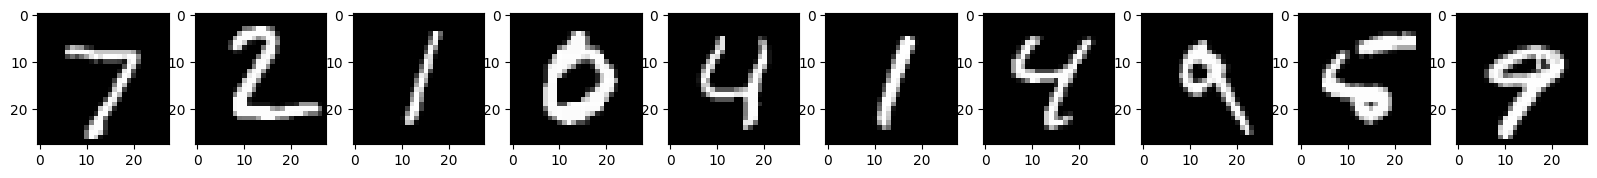

Test samples with noise (Given as input to the model)


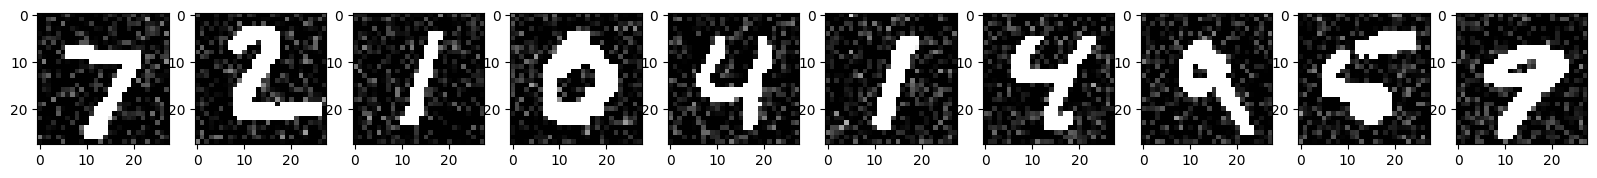

Test Samples outputs Reconstructed with model


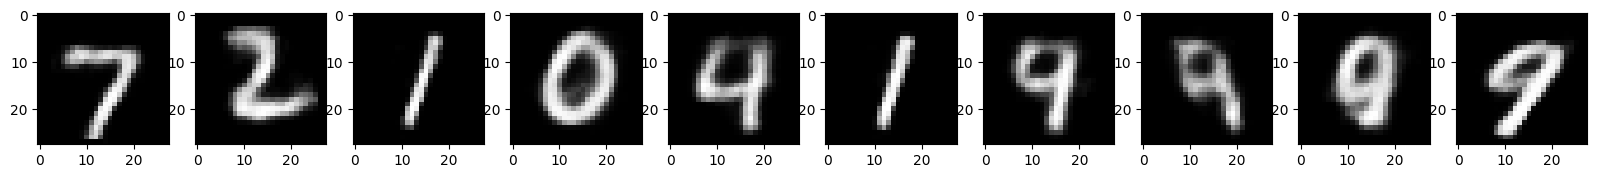

In [80]:
model_output = numpy.reshape(output.cpu().detach().numpy(), (10000,28,28)) *255
Target = numpy.reshape(dataset.Y_test, (10000,28,28)) *255
Test_input = numpy.reshape(dataset.X_test, (10000,28,28)) *255

plt.figure(figsize=(20, 4))
print("Test samples")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(Target[i-10,:,:], cmap='gray')
plt.show()

plt.figure(figsize=(20, 4))
print("Test samples with noise (Given as input to the model)")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(Test_input[i-10,:,:], cmap='gray')
plt.show()

plt.figure(figsize=(20, 4))
print("Test Samples outputs Reconstructed with model")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(model_output[i-10,:,:], cmap='gray')
    # curr_lbl = y_test[i]
plt.show()